In [1]:
import os, shutil
import pandas as pd
import numpy as np

In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import xception, resnet50, imagenet_utils, inception_v3, inception_resnet_v2
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
#from tensorboard_callback import TensorBoard

Using TensorFlow backend.


In [3]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


# 1. 数据处理

## 数据集下载
参照README.md


## 图片目录处理

为了方便使用``keras``的 ``image.ImageDataGenerator`` 来对图片数据按batch进行流化，而不是一下子加载全部图片到内存，我们需要按``ImageDataGenerator`` 的要求来整理图片路径。

In [4]:
CURRENT_DIR = os.getcwd()

# 图片原始目录
INPUT_DIR = "input"
INPUT_TRAIN_DIR = INPUT_DIR+"/train"
INPUT_TEST_DIR = INPUT_DIR+"/test"

# 处理后给模型使用的目录
TRAIN_DIR = "train"
VALIDATION_DIR = "validation"
TEST_DIR = "test"
# 放全部数据
TRAIN_DIR2 = "train2"

# 保存h5文件的目录
H5_DIR = 'h5/'

# 删除并重建目录
def rebuild_dir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    
# rebuild_dir('h5/')
# rebuild_dir('small_h5/')

In [42]:
# 重新生成所有目录    
def rebuild_all_dir():
    rebuild_dir(TRAIN_DIR)
    rebuild_dir(TRAIN_DIR+"/dog/")
    rebuild_dir(TRAIN_DIR+"/cat/")

    rebuild_dir(VALIDATION_DIR)
    rebuild_dir(VALIDATION_DIR+"/dog/")
    rebuild_dir(VALIDATION_DIR+"/cat/")
    
    rebuild_dir(TRAIN_DIR2)
    rebuild_dir(TRAIN_DIR2+"/dog/")
    rebuild_dir(TRAIN_DIR2+"/cat/")

In [5]:
# 各取多少张猫狗图片， 0~12500
TRAIN_SIZE = 2500

# 最后一次测试时，用大数据来训练
TRAIN_HUGE = True

from sklearn.model_selection import train_test_split

# 设置随机种子
np.random.seed(2018)
indexs = list(range(TRAIN_SIZE))

rebuild_all_dir()

# 生成训练集和验证集，猫狗等概率。
indexs_train, indexs_val = train_test_split(indexs, test_size=0.2)

for i in indexs_train:
    cat = 'cat.%d.jpg' % i
    dog = 'dog.%d.jpg' % i
    os.symlink('../../input/train/'+cat, TRAIN_DIR+'/cat/'+cat)   
    os.symlink('../../input/train/'+dog, TRAIN_DIR+'/dog/'+dog)   

for i in indexs_val:
    cat = 'cat.%d.jpg' % i
    dog = 'dog.%d.jpg' % i
    os.symlink('../../input/train/'+cat, VALIDATION_DIR+'/cat/'+cat)   
    os.symlink('../../input/train/'+dog, VALIDATION_DIR+'/dog/'+dog)
    
# 整合训练集和验证集，用于模型的特征提取。提取后再做训练集和验证集的拆分。
for i in range(TRAIN_SIZE):
    cat = 'cat.%d.jpg' % i
    dog = 'dog.%d.jpg' % i
    os.symlink('../../input/train/'+cat, TRAIN_DIR2+'/cat/'+cat)   
    os.symlink('../../input/train/'+dog, TRAIN_DIR2+'/dog/'+dog)

NameError: name 'rebuild_all_dir' is not defined

处理文件软链接，为了能使用ImageDataGenerator的flow_from_directory

In [6]:
# 全部数据只用于最后的测试
if TRAIN_HUGE:
    os.remove(TEST_DIR+'/test')
    os.symlink('../input/test', TEST_DIR+'/test')
    H5_DIR="h5/"
else:
    H5_DIR="small_h5/"

> 注意：改变数据集大小时，要把上面两个cell都运行

简单验证图片软连接是否生效:

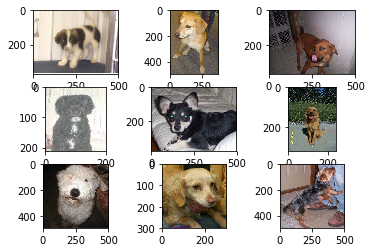

In [8]:
import matplotlib.pyplot as  plt
import glob
from PIL import Image
from keras.preprocessing import image
 
path = 'validation/dog'
 
def print_result(path):
    name_list = glob.glob(path)
    fig = plt.figure()
    for i in range(9):
        img = Image.open(name_list[i])
        sub_img = fig.add_subplot(331 + i)
        sub_img.imshow(img)
    plt.show()
    return fig

fig = print_result(path + '/*')

## 用ImageDataGenerator对图片数据进行增强，并改变大小

In [91]:
from keras.preprocessing import image

batch_size = 16

# this is the augmentation configuration we will use for training
datagen1 = image.ImageDataGenerator(
        rescale=1./255)
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = datagen1.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

datagen2 = image.ImageDataGenerator(
        rescale=1./255)

# this is a similar generator, for validation data
validation_generator = datagen2.flow_from_directory(
        VALIDATION_DIR,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# 模型

## 从简单的ConvNet开始

使用keras的Sequential，创建简单的ConvNet，测试性能。

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

simple_model = Sequential()

simple_model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
simple_model.add(Activation('relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))

simple_model.add(Conv2D(32, (3, 3)))
simple_model.add(Activation('relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))

simple_model.add(Conv2D(64, (3, 3)))
simple_model.add(Activation('relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))

simple_model.add(Flatten())
simple_model.add(Dense(64))
simple_model.add(Activation('relu'))
simple_model.add(Dropout(0.5))
simple_model.add(Dense(1))
simple_model.add(Activation('sigmoid'))

simple_model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [92]:
train_generator.reset()
validation_generator.reset()

In [88]:
simple_model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.n//batch_size)

Epoch 1/10
100/100 [==============================] - 13s 127ms/step - loss: 0.6588 - acc: 0.6063 - val_loss: 0.6628 - val_acc: 0.6375

模型准确率随着迭代次数有所提高，但验证的loss下降不明显。

## 尝试深度ConvNet

### 1. 使用预训练的ResNet50网络，并加上我们的池化、FC层。

In [97]:
base_model = resnet50.ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
resModel = Model(base_model.input, x)

In [98]:
resModel.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [99]:
train_generator.reset()
validation_generator.reset()

In [100]:
resModel.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.n//batch_size)

Epoch 1/10
100/100 [==============================] - 44s 444ms/step - loss: 0.5620 - acc: 0.7044 - val_loss: 0.7183 - val_acc: 0.5000

### 2. 配置不同的模型参数

In [7]:
from keras.preprocessing import image
from keras.applications import imagenet_utils

# 封装模型设置
def model_choice(model_name):
    return { 'Xception':
               (xception.Xception, 
                (299, 299, 3), 
                xception.preprocess_input),
            
             'InceptionResNetV2':
               (inception_resnet_v2.InceptionResNetV2, 
                (299, 299, 3), 
                inception_resnet_v2.preprocess_input),
            
             'InceptionV3':
               (inception_v3.InceptionV3, 
                (224, 224, 3), 
                imagenet_utils.preprocess_input),}.get(model_name)

### 3. 封装使用模型提取参数的逻辑

In [8]:
import h5py

def generate_features(MODEL=xception.Xception, 
                         input_shape=(299, 299, 3), 
                         batch_size=16, 
                         preprocess=xception.preprocess_input):
    
    input_tensor = Input(input_shape)
    x = input_tensor

        
    # 使用`imagenet`预训练的权重, 去掉FC层，用来提取特征map                        
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = image.ImageDataGenerator(preprocessing_function=preprocess)
                         
    # 生成训练数据集batch流
    train_generator = gen.flow_from_directory(TRAIN_DIR2,
                                            batch_size=batch_size, 
                                            shuffle=False,
                                            class_mode='binary', 
                                            target_size=input_shape[:-1])

    # 生成测试数据集batch流
    test_generator = gen.flow_from_directory(TEST_DIR,
                                            batch_size=batch_size,
                                           shuffle=False,
                                            class_mode=None, # 测试集不关心label
                                            target_size=input_shape[:-1])
    print(model.output.shape)
    
    # train 特征
    train_features = model.predict_generator(train_generator, test_generator.n/test_generator.batch_size)
    
    # test 特征
    test_features = model.predict_generator(test_generator, test_generator.n/test_generator.batch_size)
    
    # 保存训练集、验证集、测试集的features
    h5_file_name = H5_DIR + "%s.h5" % MODEL.__name__
    if os.path.exists(h5_file_name):
        os.remove(h5_file_name)
    with h5py.File(h5_file_name) as h:
        h.create_dataset("train_features", data=train_features)
        h.create_dataset("test_features", data=test_features)
        
    # 顺便保存label,label和ImageDataGenerator有关，和所选的模型无关
    h5_file_name = H5_DIR+'labels.h5'
    if os.path.exists(h5_file_name):
        return
    with h5py.File(h5_file_name) as h:
        h.create_dataset("train_labels", data=train_generator.classes)


### 4. 生成各个模型的feature并保存

* 提取Xception生成的特征，并保存

In [9]:
MODEL, input_shape, preprocess = model_choice('Xception')
generate_features(MODEL=MODEL, input_shape=input_shape, batch_size=32, preprocess=preprocess)

Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
(?, 2048)


> 用Xception生成5000+12500图片的特征，在p2.xlarge上耗时 14.5 分钟。

* 提取InceptionV3生成的特征，并保存

In [10]:
MODEL, input_shape, preprocess = model_choice('InceptionV3')
generate_features(MODEL=MODEL, input_shape=input_shape, batch_size=32, preprocess=preprocess)

Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
(?, 2048)


> 用InceptionV3生成5000+12500图片的特征，在p2.xlarge上耗时 15 分钟。

* 提取InceptionResNetV2生成的特征，并保存

In [11]:
MODEL, input_shape, preprocess = model_choice('InceptionResNetV2')
generate_features(MODEL=MODEL, input_shape=input_shape, batch_size=32, preprocess=preprocess)

Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
(?, 1536)


> 用InceptionResNetV2生成5000+12500图片的特征，在p2.xlarge上耗时 15 分钟。

### 5. 加载各个模型的feature并合并

In [12]:
import h5py

def load_features(models=None):
    X_train = []
#     y_train, y_val = [], []
    X_test = []
    
    if not models:
        models = ["Xception.h5", "InceptionV3.h5", "InceptionResNetV2.h5"]
    for f in models:
        fn = H5_DIR+f
        with h5py.File(fn, 'r') as h:
            X_train.append(np.array(h['train_features']))
            if TRAIN_HUGE:
                X_test.append(np.array(h['test_features']))
                    
    with h5py.File(H5_DIR+'labels.h5', 'r') as h:
        y_train = np.array(h['train_labels'])
        
    X_train = np.concatenate(X_train, axis=1)
    # 最后用全部数据训练时，才需要加载测试的特征
    if TRAIN_HUGE:
        X_test = np.concatenate(X_test, axis=1)
    
    return X_train, y_train, X_test

In [21]:
X_train, y_train, X_test = load_features(models=["Xception.h5", "InceptionV3.h5", "InceptionResNetV2.h5"])

In [127]:
np.random.seed(2018)

X_train, y_train = shuffle(X_train, y_train) 

### 6. 定义混合的模型

把上面三个深度模型训练的特征，加上我们的FC层，并训练。

In [13]:
from datetime import datetime
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

class EnsembleModel:
    def __init__(self, dropout_p = 0.5, batch_size = 32, input_shape=(2048,)):
        self.batch_size = batch_size
        input_tensor = Input(input_shape)
        x = Dropout(0.5)(input_tensor)
        x = Dense(1, activation='sigmoid')(x)
        self.model = Model(input_tensor, x)
        
        self.model.compile(optimizer='adadelta',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])        

        log_dir = 'logs/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
        self.tb_cb = TensorBoard(log_dir=log_dir, 
                                 batch_size=self.batch_size,)
        self.early_cb = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

    def fit(self, train_features, train_labels, valid_features, valid_labels, epochs, *args, **kwargs):
        return self.model.fit(train_features, 
                              train_labels, 
                              batch_size=self.batch_size, 
                              epochs=epochs, 
                              validation_data=(valid_features, valid_labels), 
                              callbacks=[self.tb_cb,self.early_cb], 
                              **kwargs).history
    
    def predict(self, test_features, *args, **kwargs):
        return self.model.predict(test_features, batch_size=self.batch_size, **kwargs)

In [22]:
myModel = EnsembleModel(dropout_p=0.5, batch_size=32, input_shape=(X_train.shape[1],))

训练我们的模型

In [129]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [130]:
myModel.fit(X_train, y_train, X_val, y_val, epochs=50)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 551us/step - loss: 0.3548 - acc: 0.8775 - val_loss: 0.1593 - val_acc: 0.9890

{'acc': [0.8775,
  0.98475,
  0.99075,
  0.992,
  0.993,
  0.99425,
  0.99425,
  0.9935,
  0.99475,
  0.994,
  0.9945,
  0.99475,
  0.9955,
  0.99575,
  0.995,
  0.9955,
  0.99625,
  0.997],
 'loss': [0.3548157985210419,
  0.12096631973981857,
  0.06965407156944275,
  0.04951778434216976,
  0.039286697126924994,
  0.03265152589976788,
  0.028779174115508795,
  0.028935381527990103,
  0.024450347036123275,
  0.0229846095405519,
  0.02307140118815005,
  0.02177799994125962,
  0.020309680499136448,
  0.01860569826513529,
  0.018243715343996884,
  0.015910547338426114,
  0.015367780832573771,
  0.015083001632243395],
 'val_acc': [0.989,
  0.989,
  0.99,
  0.989,
  0.99,
  0.991,
  0.991,
  0.991,
  0.992,
  0.992,
  0.992,
  0.992,
  0.992,
  0.993,
  0.993,
  0.993,
  0.993,
  0.993],
 'val_loss': [0.15932199883460998,
  0.08440787076950074,
  0.05864208945631981,
  0.045906751334667206,
  0.04065465694665909,
  0.03679863952100277,
  0.034532555863261226,
  0.03334630393236875,
  0.03225

可以看到我们只用5000个图片的训练下，验证集的loss已经达到0.0281，并提前结束训练，满足kaggle前10%的要求。

## 结果测试

In [15]:
def test_model(models):
    X_train, y_train, X_test = load_features(models=models)
    np.random.seed(2018)
    X_train, y_train = shuffle(X_train, y_train) 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    myModel = EnsembleModel(dropout_p=0.5, batch_size=32, input_shape=(X_train.shape[1],))
    myModel.fit(X_train, y_train, X_val, y_val, epochs=50)
    return myModel

### 1. 单独使用 Xception的特征

In [16]:
test_model(['Xception.h5'])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 267us/step - loss: 0.3334 - acc: 0.9387 - val_loss: 0.1782 - val_acc: 0.9920

### 2. 单独使用InceptionV3的特征

In [32]:
test_model(['InceptionV3.h5'])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 257us/step - loss: 4.5656 - acc: 0.5350 - val_loss: 2.6659 - val_acc: 0.5890

### 3. 单独使用InceptionResNetV2的特征

In [17]:
test_model(['InceptionResNetV2.h5'])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 259us/step - loss: 0.2917 - acc: 0.9150 - val_loss: 0.1389 - val_acc: 0.9870

### 4. 整合使用多模型的特征

In [19]:
myModel = test_model(["Xception.h5", "InceptionResNetV2.h5"])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 267us/step - loss: 0.2271 - acc: 0.9525 - val_loss: 0.0904 - val_acc: 0.9920

## 生成预测并提交kaggle

最后一步生summition。

In [23]:
y_pred = myModel.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 3s 206us/step


In [24]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(TEST_DIR, (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred-inceptionrestv2.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995000
1,2,0.993609
2,3,0.995000
3,4,0.976898
4,5,0.995000
5,6,0.886106
6,7,0.879489
7,8,0.995000
8,9,0.995000
9,10,0.603476


提交后，最后看到的得分是0.04093，大概前20名左右。如果加大数据训练，效果应该更好一点。